<a href="https://colab.research.google.com/github/cristhiansito123/use_pyspark/blob/main/proyecto_ensayos_clinicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estudio de ensayos clínicos realizados en el 2021**

## ***Entendimiento del problema***
### **Objetivos**


*   Realizar consultas de una base de datos acerca de los ensayos clínicos realizados por las principales entidades de salud en el 2021.
*   Comparar las principales estructuras de analizar datos que tiene spark, entre RDD y dataframes, para determinar las ventajas y desventajas que tiene cada tecnología al manejar grandes volúmenes de información.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import explode
from pyspark.sql.functions import split ,col
from pyspark.sql.functions import unix_timestamp ,col

In [ ]:
filepath = '/FileStore/tables/clinicaltrial_2021.csv'
clinicalDf =spark.read.options(delimiter='|', header ='true').csv(filepath)
clinicalDf.show(5)

+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+-------------+
|         Id|             Sponsor|              Status|   Start|Completion|                Type|Submission|          Conditions|Interventions|
+-----------+--------------------+--------------------+--------+----------+--------------------+----------+--------------------+-------------+
|NCT02758028|The University of...|          Recruiting|Aug 2005|  Nov 2021|      Interventional|  Apr 2016|                null|         null|
|NCT02751957|     Duke University|           Completed|Jul 2016|  Jul 2020|      Interventional|  Apr 2016|Autistic Disorder...|         null|
|NCT02758483|Universidade Fede...|           Completed|Mar 2017|  Jan 2018|      Interventional|  Apr 2016|   Diabetes Mellitus|         null|
|NCT02759848|Istanbul Medeniye...|           Completed|Jan 2012|  Dec 2014|       Observational|  May 2016|Tuberculosis,Lung...|         null|

Número de estudios

In [ ]:
 filepath = '/FileStore/tables/clinicaltrial_2021.csv'
clinicalrdd = sc.textFile(filepath)\
.filter(lambda x: not x.startswith('I'))
clinicalrdd.count()

Out[75]: 387261

In [ ]:
clinicalDf.count()

Out[76]: 387261

Tipo de estudios

In [ ]:
type_rdd = clinicalrdd.map(lambda x : x.split('|'))\
.map(lambda x:x[5]).map(lambda x: (x,1))
Types_of_Studies = frequency(type_rdd,5)
Types_of_Studies

Out[77]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

In [ ]:
typeDF = clinicalDf.groupBy('Type').count()
typeDF.sort('count', ascending = False).display()

Type,count
Interventional,301472
Observational,77540
Observational [Patient Registry],8180
Expanded Access,69


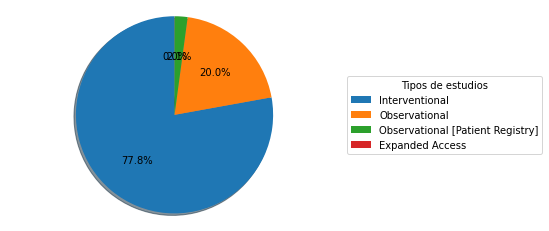

Out[79]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

In [ ]:
labels = list(map(lambda x: x[0] ,Types_of_Studies))
sizes = list(map(lambda x: x[1] ,Types_of_Studies))
fig1, ax1 = plt.subplots()

wedges, texts, autotexts =ax1.pie(sizes, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal') 

ax1.legend(wedges, labels,
          title="Tipos de estudios",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Types_of_Studies

Top 5 de Condiciones médicas

In [ ]:
condition_rdd = clinicalrdd.map(lambda x : x.split('|'))\
.map(lambda x:x[7])\
.filter(lambda x: x != u'')\
.flatMap(lambda x : x.split(','))\
.map(lambda x: (x,1))
Top_5_Conditions = frequency(condition_rdd,5)
Top_5_Conditions

Out[80]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

In [ ]:
explodeDf = clinicalDf.withColumn('Conditions',explode(split(clinicalDf['conditions'],',')))
condDF = explodeDf.select('conditions')
sorted_condDF = condDF.groupBy('Conditions').count()
sorted_condDF.sort('count', ascending = False).na.drop().limit(5).display()

Conditions,count
Carcinoma,13389
Diabetes Mellitus,11080
Neoplasms,9371
Breast Neoplasms,8640
Syndrome,8032


Out[82]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

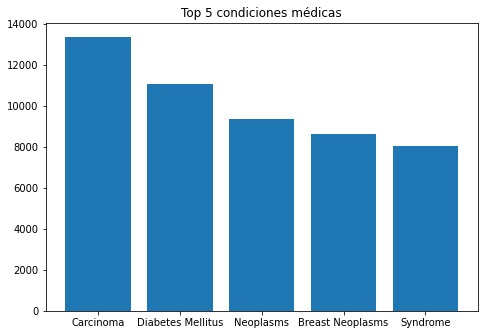

In [ ]:
x,y = zip(*Top_5_Conditions)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Top 5 condiciones médicas')
ax.bar(x,y)

Top_5_Conditions

Top 5 de salas más frecuentes

In [ ]:
meshDF = spark.read.options(delimiter=',', header ='true').csv('/FileStore/tables/mesh.csv')
meshDF.show(5)

+----------+-------------------+
|      term|               tree|
+----------+-------------------+
|Calcimycin|D03.633.100.221.173|
|   A-23187|D03.633.100.221.173|
|   Temefos|D02.705.400.625.800|
|   Temefos|D02.705.539.345.800|
|   Temefos|D02.886.300.692.800|
+----------+-------------------+
only showing top 5 rows



In [ ]:
meshrdd = sc.textFile('/FileStore/tables/mesh.csv')\
.map(lambda x: x.split(','))\
.map(lambda x:(x[0],x[1].split('.')[0]))
meshrdd.take(4)
condition_hierachy_rdd = condition_rdd.join(meshrdd).map(lambda x: (x[1][1],1))
most_frequent_roots = frequency(condition_hierachy_rdd,5)
most_frequent_roots

Out[84]: [('C04', 143994),
 ('C23', 136079),
 ('C01', 106674),
 ('C14', 94523),
 ('C10', 92310)]

In [ ]:
meshDF = spark.read.options(delimiter=',', header ='true').csv('/FileStore/tables/mesh.csv')
rootDF =  meshDF.withColumn('roots',col('tree').substr(1, 3))
joinedDF = condDF.join(rootDF,condDF.conditions == rootDF.term,'inner')
condition_rootDF = joinedDF.groupBy('roots').count()
condition_rootDF.sort('count', ascending = False).limit(5).display()

roots,count
C04,143994
C23,136079
C01,106674
C14,94523
C10,92310


Out[86]: [('C04', 143994),
 ('C23', 136079),
 ('C01', 106674),
 ('C14', 94523),
 ('C10', 92310)]

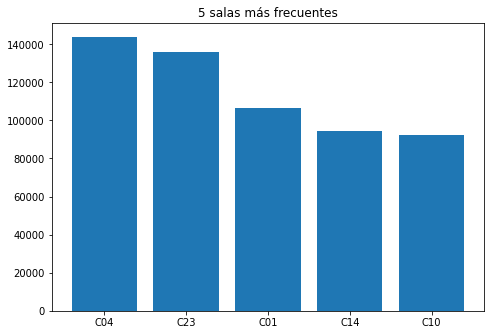

In [ ]:
a,b = zip(*most_frequent_roots)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('5 salas más frecuentes')
ax.bar(a,b)

most_frequent_roots

Los 10 laboratorios con más estudios

In [ ]:
pharma_rdd = sc.textFile('/FileStore/tables/pharma.csv')
pharma_parent_rdd = pharma_rdd.map(lambda x:(x.split(','))).map(lambda x:(x[1]).replace('"', ''))
sponsor_rdd = clinicalrdd.map(lambda x : x.split('|')).map(lambda x:x[1])
sponsor_pharma_rdd = sponsor_rdd.subtract(pharma_parent_rdd)
sponsor_pharma_pair_rdd = sponsor_pharma_rdd.map(lambda x: (x,1))
most_common_sponsors = frequency(sponsor_pharma_pair_rdd,10)
most_common_sponsors

Out[87]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

In [ ]:
pharmaDF = spark.read.options(delimiter=',', header ='true').csv('/FileStore/tables/pharma.csv')
parentcoy_DF = pharmaDF.select('Parent_Company')
sponsordf = clinicalDf.select('Sponsor')
sponsor_pharmadf = sponsordf.join(parentcoy_DF,sponsordf.Sponsor == parentcoy_DF.Parent_Company, 'leftanti') 
nopharma_sponsorDF = sponsor_pharmadf.groupBy('Sponsor').count()
nopharma_sponsorDF.sort('count', ascending = False).limit(10).display()

Sponsor,count
National Cancer Institute (NCI),3218
M.D. Anderson Cancer Center,2414
Assistance Publique - Hôpitaux de Paris,2369
Mayo Clinic,2300
Merck Sharp & Dohme Corp.,2243
Assiut University,2154
Novartis Pharmaceuticals,2088
Massachusetts General Hospital,1971
Cairo University,1928
Hoffmann-La Roche,1828


Out[89]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

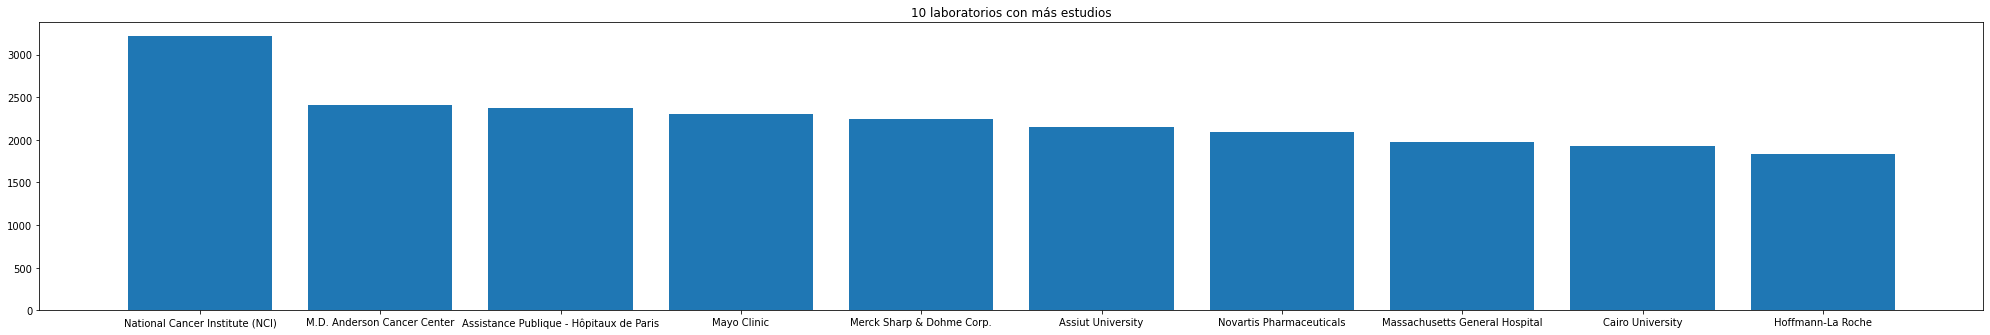

In [ ]:
a,b = zip(*most_common_sponsors)
fig = plt.figure()
ax = fig.add_axes([0,0,4.5,1])
ax.set_title('10 laboratorios con más estudios')
ax.bar(a,b)

most_common_sponsors

Número de estudios completados completados por cada mes

In [ ]:
completedstudy_rdd = clinicalrdd.map(lambda x : x.split('|'))\
.map(lambda x:[x[2],x[4]]).filter(lambda x: 'Completed' in x )\
.filter(lambda x: '2021' in x[1] )
completedstudy_pair_rdd = completedstudy_rdd.map(lambda x: (x[1].split(' ')[0]))\
.map(lambda x: (x,1)).reduceByKey(lambda x,y : x+y)
completedstudy_pair_rdd.take(5)
import calendar
month = {x:y for y,x in enumerate(calendar.month_abbr[1:],1)}
monthly_completed_study = completedstudy_pair_rdd.sortBy(keyfunc=lambda x: month.get(x[0])).collect()
monthly_completed_study


Out[90]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

In [ ]:
completeddf = clinicalDf.select('Status','Completion')
completeddf_status = completeddf.filter(completeddf.Status=='Completed')
completeddf_2021 =completeddf_status.filter(completeddf.Completion.contains('2021'))
completeddf_month = completeddf_2021.select('completion').withColumn('month', col('completion').substr(1, 3))
completeddf_sorted = completeddf_month.groupBy('month').count()
completeddf_sorted.sort(unix_timestamp(col('month'),'MMM')).display()

month,count
Jan,1131
Feb,934
Mar,1227
Apr,967
May,984
Jun,1094
Jul,819
Aug,700
Sep,528
Oct,187


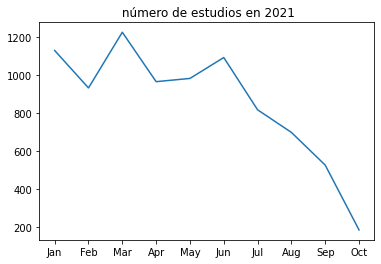

Out[92]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

In [ ]:
x,y = zip(*monthly_completed_study)
plt.plot(x,y)
plt.title(' número de estudios en 2021')
plt.show()
monthly_completed_study

# ***Conclusiones***


1.   En nuestra base de datos se observó una tendencia que las enfermedades que tenían mayor cantidad de estudios autorizados eran el cáncer y la diabetes, con una tendencia mayor a los cáncer de piel y mama. A pesar de que las enfermedades respiratorias son de las que más muertes trae en el mundo, en una época de pandemia estos estudios se vieron reducidos principalmente por las cuarentenas y el distanciamiento social que evitó tanto el aumento del covid-19 como de otras enfermedades respiratorias.
2.   En el caso de la tecnología RDD y dataframe, se observó que cuando se trataban de operaciones simples ambas tecnologías tenían un tiempo similar de ejecución, pero cuando las operaciones de búsqueda se hacían más complejas el tiempo de la tecnología RDD aumentaba considerablemente con respecto a los dataframe.
 %md